# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 8) ## default size
import seaborn as sns
import folium 
import geopandas as gpd
from pandas_profiling import ProfileReport

geo_df = gpd.read_file('us_state.json')
geo_df.rename(columns={'NAME':'State', 'STATE':'State Code'}, inplace=True)
geo_df.head()

GEO_ID State Code          State LSAD  CENSUSAREA  \
0  0400000US23         23          Maine        30842.923   
1  0400000US25         25  Massachusetts         7800.058   
2  0400000US26         26       Michigan        56538.901   
3  0400000US30         30        Montana       145545.801   
4  0400000US32         32         Nevada       109781.180   

                                            geometry  
0  MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...  
1  MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ...  
2  MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ...  
3  POLYGON ((-104.05770 44.99743, -104.25015 44.9...  
4  POLYGON ((-114.05060 37.00040, -114.04999 36.9...

# load cleaned data

In [5]:
act = pd.read_csv('data/act.csv') # 51 states * 3 years (153 rows)
sat = pd.read_csv('data/sat.csv') # 51 states * 3 years (153 rows)
both = pd.read_csv('data/both.csv') # 51 states * 3 years (153 rows)
both2 = pd.read_csv('data/both2.csv') # 51 states * 3 years * 2 tests (306 rows)

both

Year          State  Participation_ACT  Composite_ACT  Participation_SAT  \
0    2017        Alabama               1.00           19.2               0.05   
1    2017         Alaska               0.65           19.8               0.38   
2    2017        Arizona               0.62           19.7               0.30   
3    2017       Arkansas               1.00           19.4               0.03   
4    2017     California               0.31           22.8               0.53   
..    ...            ...                ...            ...                ...   
148  2019       Virginia               0.21           24.0               0.68   
149  2019     Washington               0.24           22.1               0.70   
150  2019  West Virginia               0.49           20.8               0.99   
151  2019      Wisconsin               1.00           20.3               0.03   
152  2019        Wyoming               1.00           19.8               0.03   

     EBRW  Math  Total_SAT  
0     593   572       1165  
1     547   533       1080  
2     563   553       1116  
3     614   594       1208  
4     531   524       1055  
..    ...   ...        ...  
148   567   551       1119  
149   539   535       1074  
150   483   460        943  
151   635   648       1283  
152   623   615       1238  

[153 rows x 8 columns]

In [6]:
both2

Year          State  Participation   Total Test
0    2017        Alabama           1.00    19.2  ACT
1    2017         Alaska           0.65    19.8  ACT
2    2017        Arizona           0.62    19.7  ACT
3    2017       Arkansas           1.00    19.4  ACT
4    2017     California           0.31    22.8  ACT
..    ...            ...            ...     ...  ...
301  2019       Virginia           0.68  1119.0  SAT
302  2019     Washington           0.70  1074.0  SAT
303  2019  West Virginia           0.99   943.0  SAT
304  2019      Wisconsin           0.03  1283.0  SAT
305  2019        Wyoming           0.03  1238.0  SAT

[306 rows x 5 columns]

# visualization
## correlations

In [7]:
## examples of 2017
## drop columns of each subject
col_to_drop = ['State','Year','EBRW','Math']

both[both['Year']==2017].drop(col_to_drop, axis=1).corr()

Participation_ACT  Composite_ACT  Participation_SAT  \
Participation_ACT           1.000000      -0.858134          -0.841234   
Composite_ACT              -0.858134       1.000000           0.694748   
Participation_SAT          -0.841234       0.694748           1.000000   
Total_SAT                   0.701477      -0.445020          -0.867540   

                   Total_SAT  
Participation_ACT   0.701477  
Composite_ACT      -0.445020  
Participation_SAT  -0.867540  
Total_SAT           1.000000

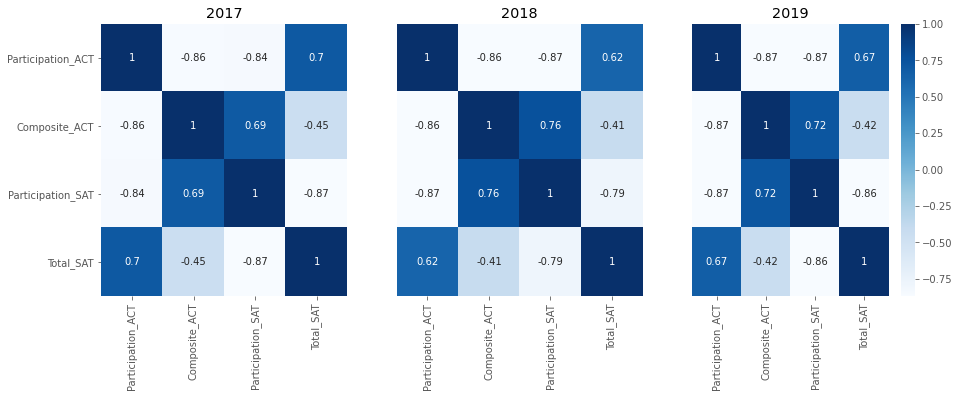

In [18]:
## to heatmap
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, year in enumerate(range(2017, 2020)):
    sns.heatmap(
        both[both['Year']==year].drop(col_to_drop, axis=1).corr(),
        ax=axes[i],
        cmap='Blues',
        yticklabels=[True,False,False][i], 
        cbar=[False,False,True][i], ## color bar for rightmost only
        annot=True).set_title(year)

## scatter

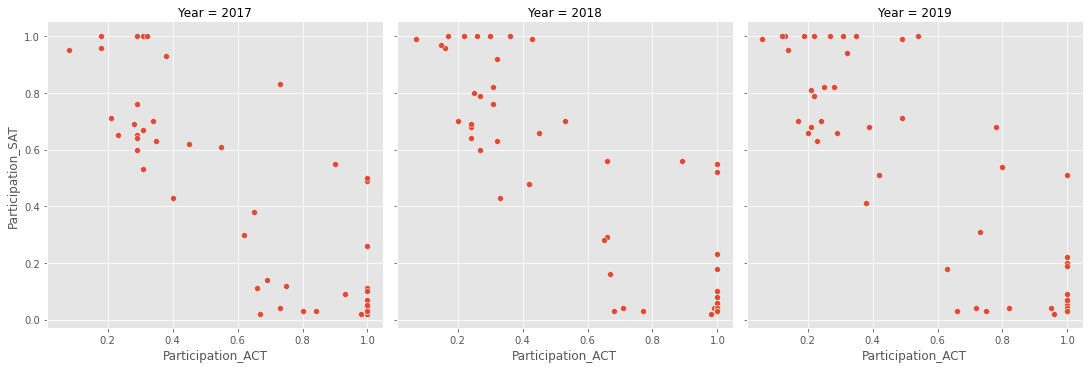

In [25]:
sns.relplot(
    data=both, 
    x="Participation_ACT", 
    y="Participation_SAT",
    col="Year",
    kind="scatter"
)

## barplot

Text(0.5, 1.0, 'mean of particiaption')

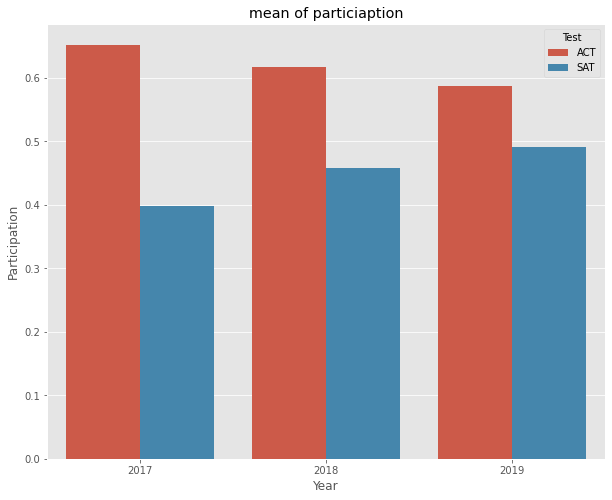

In [26]:
sns.barplot(
    x='Year',
    y='Participation',
    hue='Test',
    ci=None,
    data=both2).set_title('mean of particiaption')

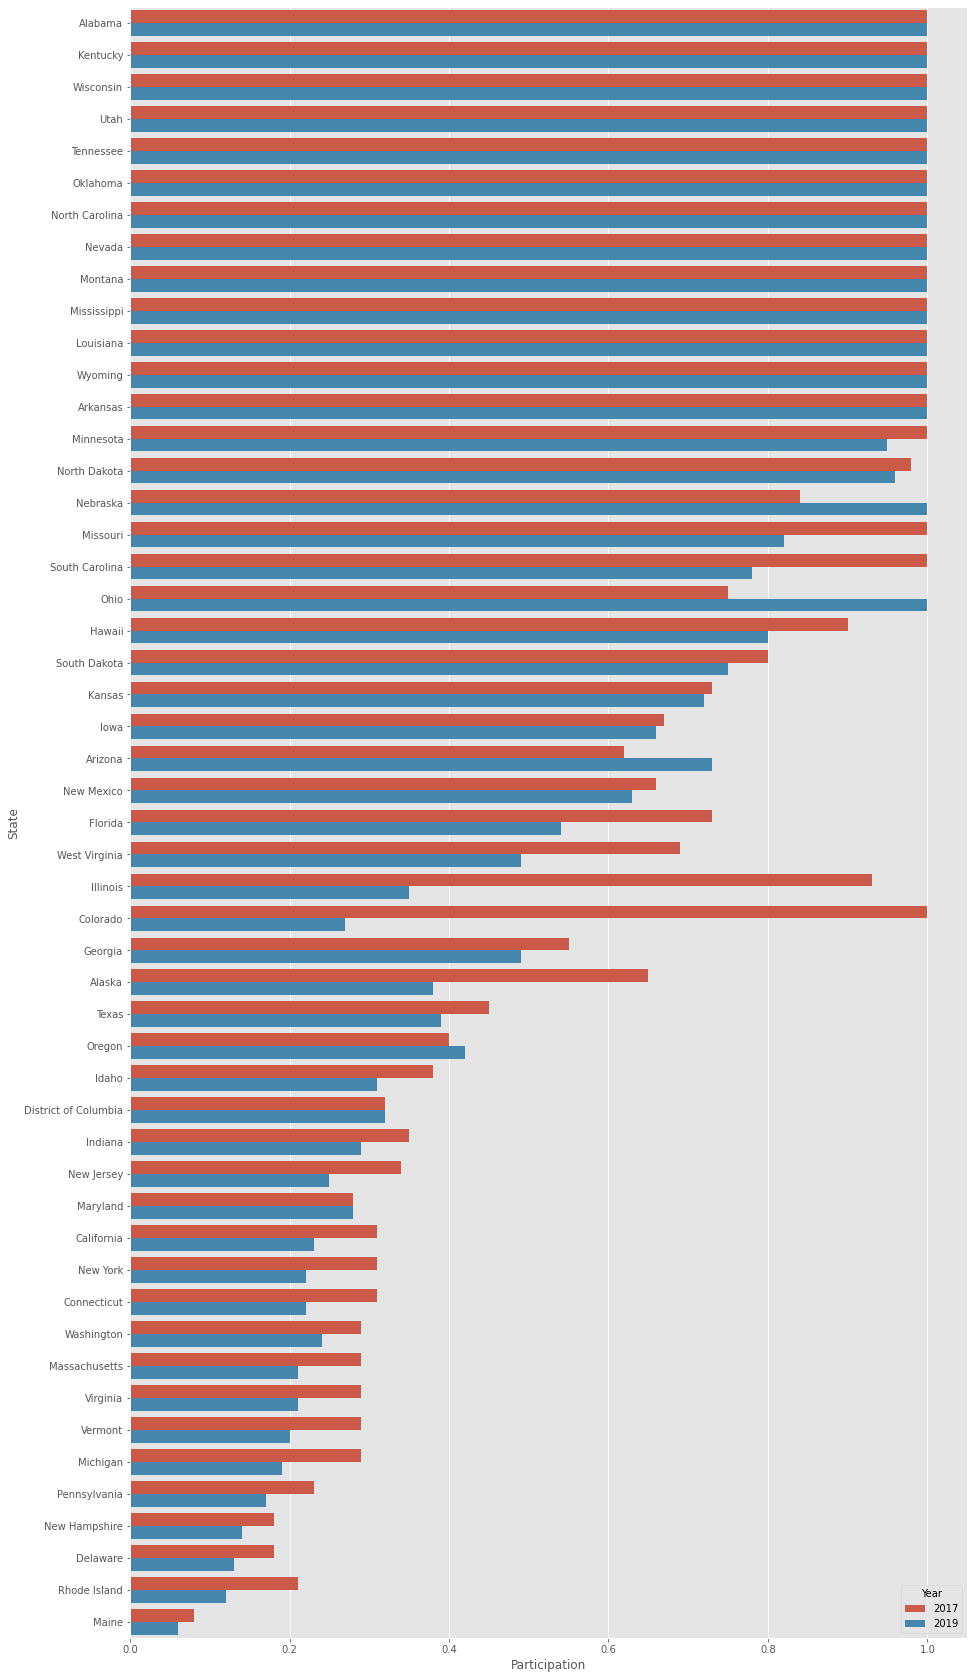

In [35]:
plt.figure(figsize=(15, 30))
sns.barplot(
    y='State',
    x='Participation',
    hue='Year',
    order=act.groupby('State')['Participation'].mean().sort_values(ascending=False).index,
    data=act[act.Year.isin([2017,2019])])

## histgram

In [53]:
## calculate z-score (standardized score) fo ACT and SAT in order to compare
## actually, sklearn has function for it
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

zs = scaler.fit_transform(both[['Composite_ACT','Total_SAT']]).T 
both['z_ACT'] = zs[0]
both['z_SAT'] = zs[1]
"""

## implement by myself
def z_score(value_list):
    m = np.mean(value_list)
    s = np.std(value_list)
    return [(x-m)/s for x in value_list]

both['z_ACT'] = z_score(both['Composite_ACT'])
both['z_SAT'] = z_score(both['Total_SAT'])

In [ ]:

sns.histplot(
    x='z_ACT',
    data=both,
    bins=40,
    color='r',
    element='step',
    label='ACT'
)
sns.histplot(
    x='z_SAT',
    data=both,
    bins=40,
    element='step',
    label='SAT'
)
plt.title('Standardized Score of ACT and SAT')
plt.legend()

## map

In [29]:
# Initialize folium map.
act2017_map = folium.Map(
    location=[38, -100],
    zoom_start=4,
    tiles='cartodbpositron'
)
# Set up Choropleth map
folium.Choropleth(
    geo_data=geo_df,
    data=both[both['Year']==2017],
    columns=['State',"Participation_ACT"],
    key_on="feature.properties.State",
    fill_color='YlGnBu',
    fill_opacity=0.2,
    line_opacity=0.5,
    legend_name="Participation",
    smooth_factor=0,
    Highlight= True,
    line_color = "#0000"
).add_to(act2017_map)

act2017_map

In [30]:
# Initialize folium map.
sat2017_map = folium.Map(
    location=[38, -100],
    zoom_start=4,
    tiles='cartodbpositron'
)
# Set up Choropleth map
folium.Choropleth(
    geo_data=geo_df,
    data=both[both['Year']==2017],
    columns=['State',"Participation_SAT"],
    key_on="feature.properties.State",
    fill_color='YlGnBu',
    fill_opacity=0.2,
    line_opacity=0.5,
    legend_name="Participation",
    smooth_factor=0,
    Highlight= True,
    line_color = "#0000"
).add_to(sat2017_map)

sat2017_map